In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports and parameter defining

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
!pip install ml_things
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


set_seed(123)
epochs = 8
batch_size = 32
learning_rate = 1e-4
max_length = 160

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get model name
model_name_or_path = 'gpt2'


# String labels to number ids.
labels_ids = {'appeal_to_fear_prejudice': 0, 'causal_oversimplification': 1, 'doubt':2, 'exaggeration,minimisation':3, 'flag_waving':4, 'loaded_language':5, 'name_calling,labeling':6, 'repetition':7}

n_labels = len(labels_ids) # get number of labels for training, used to decide size of classification head.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.8 MB/s eta 0:00:00
  Created wheel for ml_things: filename=ml_things-0.0.1-py3-none-any.whl size=24393 sha256=8d48299ab95a597f62aa603ad4a923d7f6ee5c7a0b40ecc95ccd38747b047ad8
  Stored in directory: /root/.cache/pip/wheels/2a/b9/36/3725744c1d8ebec00cd847c9461b4352ce08de9d3f20b6bdcf
Successfully built ml_things


# **Creating Dataset and Dataloader**

In [ ]:
class PropagandaDetectorDataset(Dataset):
  """
    PyTorch Dataset class for loading data.
  """

  def __init__(self, path, use_tokenizer):
    """
      arguments:
        path: path to partitioned, preprocessed data
    """
    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')

    self.texts = []
    self.labels = []

    # for each label...
    for label in ['appeal_to_fear_prejudice', 'causal_oversimplification', 'doubt', 'exaggeration,minimisation', 'flag_waving', 'loaded_language', 'name_calling,labeling', 'repetition']:

      # Get path of that class
      propaganda_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(propaganda_path)

      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(propaganda_path, file_name)
        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

      # get numbe rof labels.
      self.n_examples = len(self.labels)

    return

  def __len__(self):
    """
    returns the number of examples.
    """
    return self.n_examples

  def __getitem__(self, item):
    """
    Given an index, return an example from the position.
    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    """
    Data Collator.

    Uses a given tokenizer and label encoder to convert any text and labels to representation that can go straight into a GPT2 model.

    Args:

      use_tokenizer: tokenizer used to process raw text into numbers.

      labels_ids: Dictionary to encode labels to numbers.

      max_sequence_len: Value to indicate the maximum desired sequence to truncate or pad text sequences to.
    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to use
        self.use_tokenizer = use_tokenizer

        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        # Label encoder to use
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):

        #get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]

        #get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]

        #encode all labels
        labels = [self.labels_encoder[label] for label in labels]

        #call tokenizer on all texts to convert into tensors
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)

        #update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  """
  Train pytorch model on a single pass through the data loader.

  uses global variable 'model' which is the transformer model loaded on device_.


  Arguments:

      dataloader: Parsed data into batches of tensors.

      optimizer_: Optimizer used for training.

      scheduler_: PyTorch scheduler.

      device_: Device used to load tensors.

  Returns:

      :obj:`[True Labels, Predicted Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  #tracking variables.
  predictions_labels = []
  true_labels = []

  #total loss for this epoch.
  total_loss = 0

  #put the model in training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    outputs = model(**batch)

    # Pull loss and logits for later use
    loss, logits = outputs[:2]

    #accumulate loss.
    total_loss += loss.item()

    # Perform backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0, prevents gradients exploding.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #optimise gradients
    optimizer_.step()

    # update learning rate.
    scheduler_.step()

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # convert logits to list of predicted labels ints.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # return all true labels and prediction for future eval.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  """
  Validation function to evaluate model performance on validation set.

  Args:

    dataloader: Parsed data into batches of tensors.

    device_: Device used to load tensors.

  Returns:

    :obj: [True Labels, Predicted Labels, Average Loss]
  """


  global model

  # tracking variables
  predictions_labels = []
  true_labels = []

  #total loss for this epoch.
  total_loss = 0

  # Put model in evaluation mode
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # do not to compute or store gradients, don't need them for validation
    with torch.no_grad():

        # forward pass, calculate logit predictions.
        outputs = model(**batch)

        # get logits & loss
        loss, logits = outputs[:2]

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # accumulate validation loss
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # return true labels and predicitons
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Load Model and Tokenizer**


In [ ]:
# get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# get model tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# define padding Token
tokenizer.pad_token = tokenizer.eos_token


# get model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# move model to gpu.
model.to(device)
print(f'Model loaded to {device}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to cuda


# Create Datasets, Dataloaders and Collator

In [ ]:
# create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# create pytorch dataset.
train_dataset = PropagandaDetectorDataset(path='/content/drive/MyDrive/ANLE_Coursework/Data/propaganda_train',
                               use_tokenizer=tokenizer)
print(f'Created `train_dataset` with {len(train_dataset)} examples')

# move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print(f'Created train_dataloader with {len(train_dataloader)} batches')

print()

print('Dealing with Validation...')
# create pytorch dataset.
valid_dataset =  PropagandaDetectorDataset(path='/content/drive/MyDrive/ANLE_Coursework/Data/propaganda_val',
                               use_tokenizer=tokenizer)
print(f'Created valid_dataset with {len(valid_dataset)} examples!')

# move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print(f'Created eval_dataloader with {len(valid_dataloader)} batches!')

Dealing with Train...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


appeal_to_fear_prejudice files:   0%|          | 0/151 [00:00<?, ?it/s]

causal_oversimplification files:   0%|          | 0/158 [00:00<?, ?it/s]

doubt files:   0%|          | 0/144 [00:00<?, ?it/s]

exaggeration,minimisation files:   0%|          | 0/164 [00:00<?, ?it/s]

flag_waving files:   0%|          | 0/148 [00:00<?, ?it/s]

loaded_language files:   0%|          | 0/154 [00:00<?, ?it/s]

name_calling,labeling files:   0%|          | 0/157 [00:00<?, ?it/s]

repetition files:   0%|          | 0/147 [00:00<?, ?it/s]

Created `train_dataset` with 1223 examples
Created train_dataloader with 39 batches

Dealing with Validation...


appeal_to_fear_prejudice files:   0%|          | 0/43 [00:00<?, ?it/s]

causal_oversimplification files:   0%|          | 0/31 [00:00<?, ?it/s]

doubt files:   0%|          | 0/38 [00:00<?, ?it/s]

exaggeration,minimisation files:   0%|          | 0/28 [00:00<?, ?it/s]

flag_waving files:   0%|          | 0/39 [00:00<?, ?it/s]

loaded_language files:   0%|          | 0/37 [00:00<?, ?it/s]

name_calling,labeling files:   0%|          | 0/31 [00:00<?, ?it/s]

repetition files:   0%|          | 0/32 [00:00<?, ?it/s]

Created valid_dataset with 279 examples!
Created eval_dataloader with 9 batches!


## **Training**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/8 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 2.23401 - val_loss: 1.91415 - train_acc: 0.20442 - valid_acc: 0.22581


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 1.74263 - val_loss: 1.72566 - train_acc: 0.30581 - valid_acc: 0.39068


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 1.50821 - val_loss: 1.58796 - train_acc: 0.43254 - valid_acc: 0.40502


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 1.26499 - val_loss: 1.62115 - train_acc: 0.52903 - valid_acc: 0.44444


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 1.04929 - val_loss: 1.55406 - train_acc: 0.61079 - valid_acc: 0.54839


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 0.92295 - val_loss: 1.48418 - train_acc: 0.67702 - valid_acc: 0.59140


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 0.74768 - val_loss: 1.55121 - train_acc: 0.73426 - valid_acc: 0.57706


Training on batches...


  0%|          | 0/39 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/9 [00:00<?, ?it/s]

  train_loss: 0.69757 - val_loss: 1.49546 - train_acc: 0.74652 - valid_acc: 0.60932



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


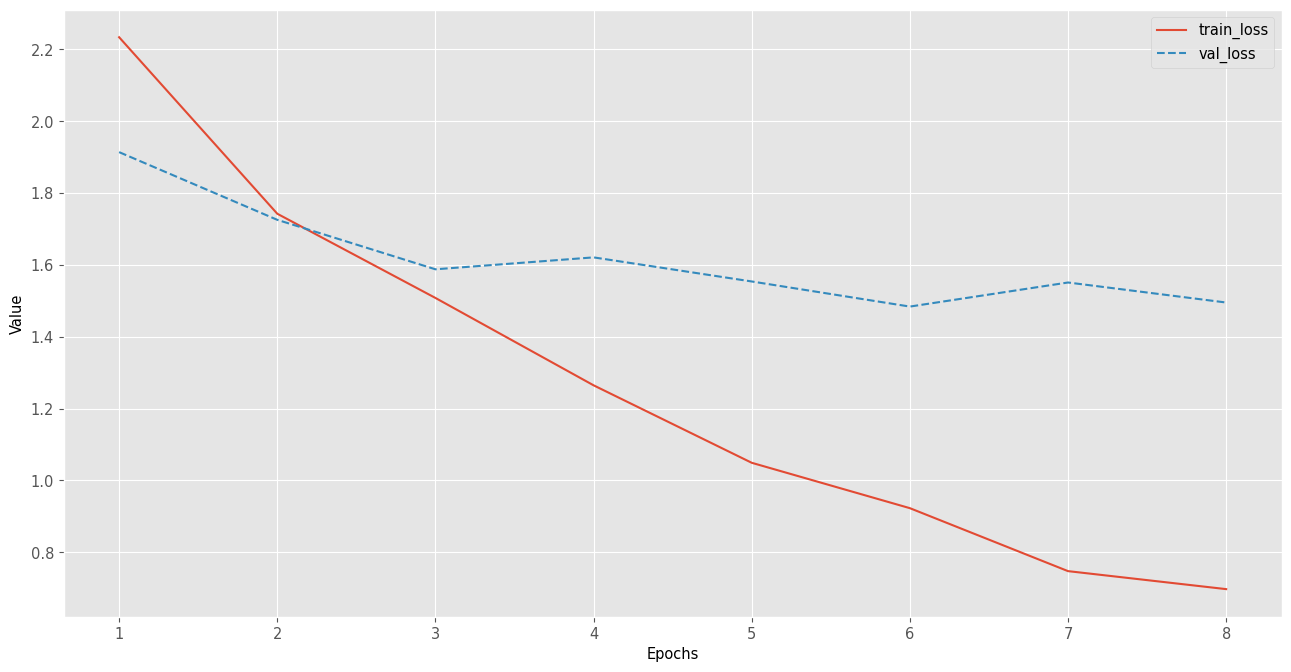

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


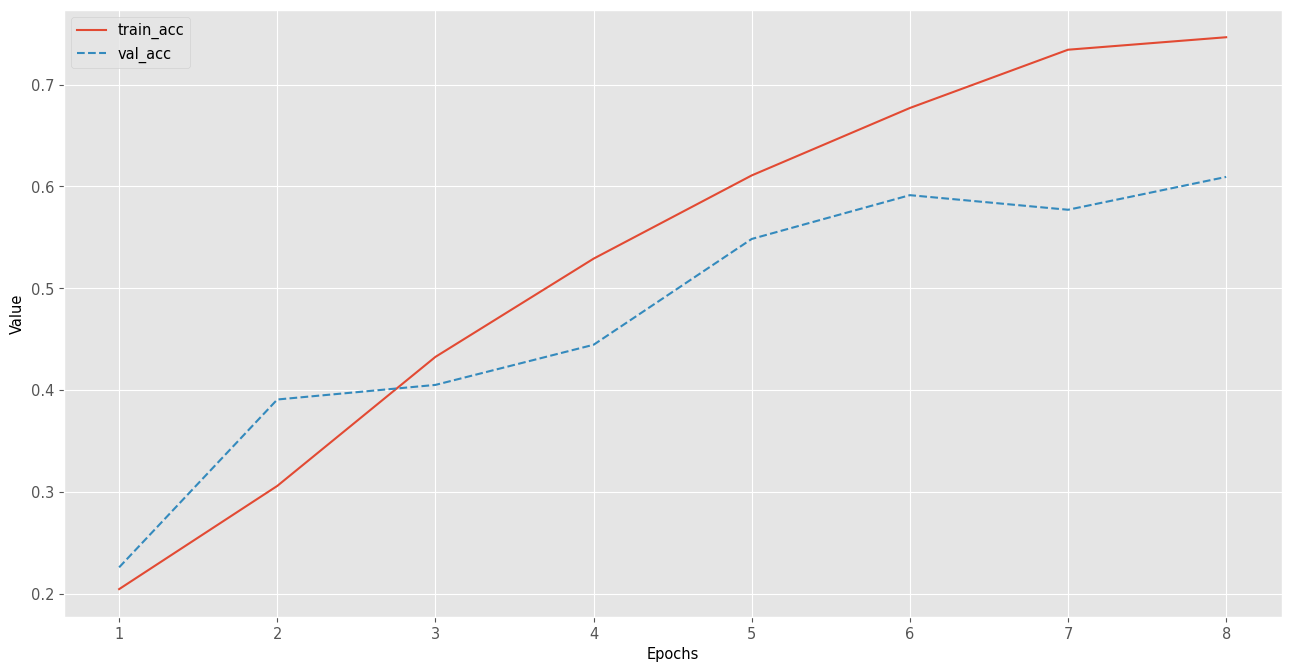

In [ ]:

# define optimiser
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # default is 5e-5,
                  eps = 1e-8 # default is 1e-8.
                  )

# calculate total number of steps
total_steps = len(train_dataloader) * epochs

# create lr scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# atore the average loss after each epoch so they can be plotted.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

#loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## **Evaluation**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/9 [00:00<?, ?it/s]

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.75      0.56      0.64        43
causal_oversimplification       0.48      0.65      0.55        31
                    doubt       0.52      0.58      0.55        38
exaggeration,minimisation       0.43      0.43      0.43        28
              flag_waving       0.75      0.85      0.80        39
          loaded_language       0.69      0.59      0.64        37
    name_calling,labeling       0.66      0.74      0.70        31
               repetition       0.58      0.44      0.50        32

                 accuracy                           0.61       279
                macro avg       0.61      0.60      0.60       279
             weighted avg       0.62      0.61      0.61       279

epochs: 8, learning rate:0.0001, max length:160
Normalized confusion matrix


/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


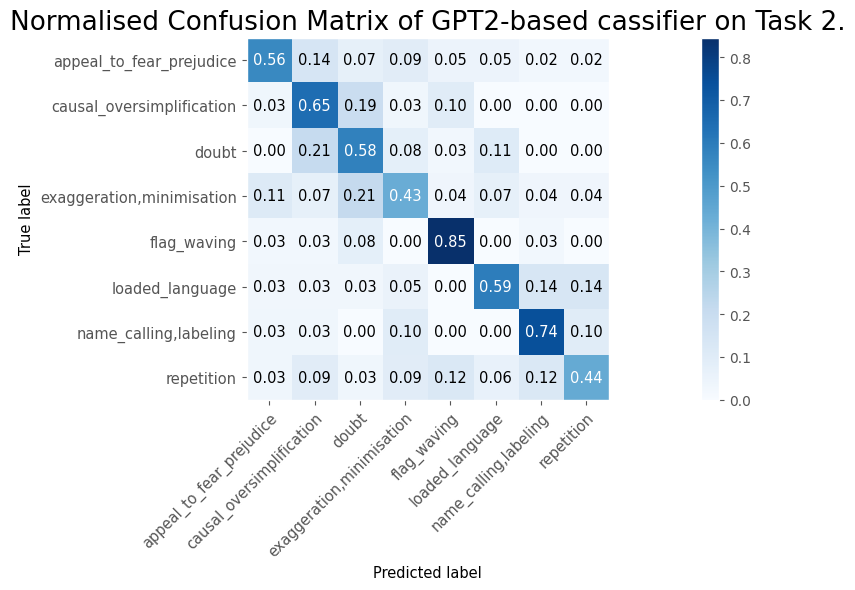

In [ ]:
# Get prediction form model on validation data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show evaluation report.
print(evaluation_report)
print(f"epochs: {epochs}, learning rate:{learning_rate}, max length:{max_length}")
# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, classes=list(labels_ids.keys()), normalize=True, title="Normalised Confusion Matrix of GPT2-based cassifier on Task 2.", magnify=0.1);